# Survival Analysis
- Reference
  - https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#

## Import

In [1]:
!pip install lifelines

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.statistics import multivariate_logrank_test

## Data
- Telco customer churn: IBM dataset
  - source: https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset?resource=download
  - 内容：固定電話およびインターネットサービスを提供している架空の電話会社における顧客の解約に関するデータ
  - 変数（適当に抜粋）：

    - 契約期間
      - Tenure Months（当月までの継続月数）

    - イベント発生有無
      - Churn Value（当月解約有無）: 1=当月に解約した, 0=当月に解約していない（継続中）
        - 前月以前に解約した顧客は含まれていない模様
    
    - 説明変数

      - 顧客属性
        - Gender (性別): Male, Female
        - City (居住地): Los Angeles, Beverly Hills, etc
        - Senior Citizen (65歳以上か): Yes, No
        - Partner (パートナーがいるか): Yes, No
        - Dependents (扶養家族がいるか): Yes, No
      
      - 契約状況
        - Phone Service (固定電話を契約しているか): Yes, No
        - Multiple Lines (複数の電話回線を契約しているか): Yes, No, No phone service
        - Internet Service (インターネットを契約しているか): DSL, Fiber optic, No
        - Contract (契約タイプ): Month-to-Month, One Year, Two Year.
      
      - 利用料金関連
        - Paperless Billing (請求書を電子で受け取るか): Yes, No
        - Payment Method (支払い方法): Mailed check, Electronic check, Bank transfer (automatic), Credit card (automatic)
        - Monthly Charges (月額利用料金)
        - Total Charges (これまでの利用料金計)

      - 追加サービス利用有無
        - Online Security (online serurity serviceに加入しているか): Yes, No, No internet service
        - Online Backup (online backup serviceに加入しているか): Yes, No, No internet service
        - Device Protection (device protection planに加入しているか): Yes, No, No internet service
        - Tech Support (technical support planに加入しているか): Yes, No, No internet service
        - Streaming TV (インターネットを利用してTVを観ているか): Yes, No, No internet service
        - Streaming Movies (インターネットを利用して映画を観ているか): Yes, No, No internet service


In [3]:
# Load
df = pd.read_csv('Telco_customer_churn.csv', index_col=0, encoding='utf-8').reset_index()
df.head(1)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer


In [4]:
# Check
print(df.shape)
print(df.dtypes)

(7043, 33)
CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Score            int64
CLTV                   int64
Churn Reason          object
dtype: object


In [5]:
# 加工

# カラム名の空白を_で置き換え
df.columns = df.columns.str.replace(' ', '_')

# Yes/Noを1/0に変換
list_of_cols = ['Senior_Citizen', 'Partner', 'Dependents', 'Phone_Service', 'Paperless_Billing']
df[list_of_cols] = df[list_of_cols].replace({'Yes': 1, 'No': 0})

# その他変換
df['Gender'] = df['Gender'].replace({'Male':1, 'Female':0})
df['Multiple_Lines'] = df['Multiple_Lines'].replace({'Yes': 1, 'No': 0, 'No phone service': 0})
df['Online_Security'] = df['Online_Security'].replace({'Yes': 1, 'No': 0, 'No internet service': 0})

df.head(3)

,CustomerID,Count,Country,State,City,Zip_Code,Lat_Long,Latitude,Longitude,Gender,...,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Label,Churn_Value,Churn_Score,CLTV,Churn_Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,1,...,Month-to-month,1,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,0,...,Month-to-month,1,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,0,...,Month-to-month,1,Electronic check,99.65,820.5,Yes,1,86,5372,Moved


In [6]:
# モデルに突っ込む用df
vars = ['Tenure_Months',
        'Churn_Value',
        'Gender',
        'Senior_Citizen',
        'Partner',
        'Dependents',
        'Phone_Service',
        'Multiple_Lines',
        'Paperless_Billing',
        'Monthly_Charges',
        'Online_Security'
]
df_limited = df[vars]
df_limited.head(3)

,Tenure_Months,Churn_Value,Gender,Senior_Citizen,Partner,Dependents,Phone_Service,Multiple_Lines,Paperless_Billing,Monthly_Charges,Online_Security
0,2,1,1,0,0,0,1,0,1,53.85,1
1,2,1,0,0,0,1,1,0,1,70.70,0
2,8,1,0,0,0,1,1,1,1,99.65,0


In [7]:
# correlation
df_limited.corr()

,Tenure_Months,Churn_Value,Gender,Senior_Citizen,Partner,Dependents,Phone_Service,Multiple_Lines,Paperless_Billing,Monthly_Charges,Online_Security
Tenure_Months,1.000000,-0.352229,0.005106,0.016567,0.379697,0.131376,0.008448,0.331941,0.006152,0.247900,0.327203
Churn_Value,-0.352229,1.000000,-0.008612,0.150889,-0.150448,-0.248542,0.011942,0.040102,0.191825,0.193356,-0.171226
Gender,0.005106,-0.008612,1.000000,-0.001874,-0.001808,0.005229,-0.006488,-0.008414,-0.011754,-0.014569,-0.017021
Senior_Citizen,0.016567,0.150889,-0.001874,1.000000,0.016479,-0.174396,0.008576,0.142948,0.156530,0.220173,-0.038653
Partner,0.379697,-0.150448,-0.001808,0.016479,1.000000,0.363430,0.017706,0.142057,-0.014877,0.096848,0.143106
Dependents,0.131376,-0.248542,0.005229,-0.174396,0.363430,1.000000,0.000625,-0.027510,-0.118963,-0.144206,0.050353
Phone_Service,0.008448,0.011942,-0.006488,0.008576,0.017706,0.000625,1.000000,0.279690,0.016505,0.247398,-0.092893
Multiple_Lines,0.331941,0.040102,-0.008414,0.142948,0.142057,-0.027510,0.279690,1.000000,0.163530,0.490434,0.098108
Paperless_Billing,0.006152,0.191825,-0.011754,0.156530,-0.014877,-0.118963,0.016505,0.163530,1.000000,0.352150,-0.003636
Monthly_Charges,0.247900,0.193356,-0.014569,0.220173,0.096848,-0.144206,0.247398,0.490434,0.352150,1.000000,0.296594


## Estimation
- Cox比例ハザードモデル
  - 準備
    - 解約率
      - $f(t)$: 期間tが経過した時点で（ある時点tにおいて）解約する確率（確率密度関数）
      - $F(t)$: 期間tが経過するまでに（ある時点tまでのいずれかの時点で）解約している確率（累積分布関数）
    - 生存関数（survival function）
      - $S(t)$: 期間tが経過するまで契約を継続している確率（=1-F(t)）
    - ハザード関数（hazard function）またはハザード率（hazard rate）
      - $h(t)$: 時点tにおいて解約する確率 / 時点tまで契約を継続している確率（=$f(t)/S(t)$）
      - ある時点tまで継続したという条件の下で時点tにおいて解約する確率（＝条件付き確率）
      - なぜハザード関数を考えるか
        - t=1における解約者数とt=10における解約者数を比較すると，通常は後者の方が小さくなる
        - 故に単純に解約率で比較すると，仮に解約のしやすさがt=1とt=30で等しかったとしても後者の方が小さくなる
        - ハザード関数を考えることで，解約のしやすさを正しく把握することができる
  - 推定式：$h(t) = h_{0}(t) exp(\beta_{1}x_{1} + \beta_{2}x_{2} + \cdots + \beta_{k}x_{k})$
    - 概要
      - 全ての顧客に共通のベースラインハザード$h_{0}(t)$と，顧客ごとの相対ハザード$exp(\beta_{1}x_{1} + \beta_{2}x_{2} + \cdots + \beta_{k}x_{k})$をかけ合わせることで顧客ごとのハザード率$h(t)$が決まる（相対ハザードは各顧客の説明変数の値$x_{1}, x_{2}, \cdots$によって決まる）．
      - 各顧客のハザード率$h(t)$は，全顧客に共通するベースラインハザードの何倍（倍率は説明変数によって決まる），つまりベースラインハザードに比例する形で決まるため，比例ハザードモデルと呼ばれる
      - ベースラインハザード$h_{0}(t)$の形に仮定をおかず，どの説明変数がどの程度ハザード率に影響を与えているかを知ること（$\beta_{1}, \beta_{2}, \cdots$の推定）に主眼を置いたモデルである．
    - 推定方法
      - 最尤法（Maximum Likelihood Estimation: MLE）により推定する
      - ただしベースラインハザードを推定しないため，データが持つ一部の情報のみを利用して推定を行なう．そのため，ここでの尤度は通常の尤度ではなく部分尤度（partial likelihood）となり，部分尤度関数を最大化することにより推定を行なう．

In [8]:
# Fit
cph = CoxPHFitter()
cph.fit(df_limited, duration_col='Tenure_Months', event_col='Churn_Value')

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

## Result
- Interpretation
  - 説明変数Xのcoefが正：Xはハザード率を上げる（解約率を上げる方向に働いている）＝Xが大きいほど早く解約する確率が高い（契約期間が短い）
  - a one unit increase in X means the baseline hazard will increase by a factor of exp(coef) (increase by (exp(coef)-1)×100%)
    - Ex. 説明変数Multiple_Linesのexp(coef)=0.56 ⇔ 複数回線を契約している顧客はそうでない顧客よりハザード率が44%低い（＝複数回線を契約している顧客の方が長く継続しやすい）

In [9]:
# Result
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'Tenure_Months'
                event col = 'Churn_Value'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -14931.33
         time fit was run = 2024-01-21 08:04:58 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
Gender             -0.03       0.97       0.05            -0.12             0.06                 0.89                 1.06
Senior_Citizen      0.21       1.23       0.06             0.10             0.31                 1.10                 1.37
Partner            -0.64       0.53       0.05            -0.74            -0.54                 0.48                 0.58
Dependents         -1.33       0.27       0.10            -1.53            -1.12                 0.22                 0.32
Phone_Service      -0.05       0.95       0.09            -0.22             0.12                 0.80                 1.13
Multiple_Lines     -0.58       0.56       0.05            -0.69            -0.48                 0.50                 0.62
Paperless_Billing   0.45       1.56       0.06             0.33             0.56                 1.40                 1.75
Monthly_Charges     0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
Online_Security    -1.22       0.29       0.07            -1.35            -1.10                 0.26                 0.33

                    cmp to      z      p   -log2(p)
covariate                                          
Gender                0.00  -0.60   0.55       0.87
Senior_Citizen        0.00   3.75 <0.005      12.45
Partner               0.00 -12.53 <0.005     117.23
Dependents            0.00 -12.82 <0.005     122.50
Phone_Service         0.00  -0.56   0.58       0.79
Multiple_Lines        0.00 -10.62 <0.005      85.07
Paperless_Billing     0.00   7.79 <0.005      47.03
Monthly_Charges       0.00  10.68 <0.005      86.00
Online_Security       0.00 -18.58 <0.005     253.60
---
Concordance = 0.75
Partial AIC = 29880.66
log-likelihood ratio test = 1443.42 on 9 df
-log2(p) of ll-ratio test = 1011.50

<Axes: xlabel='log(HR) (95% CI)'>

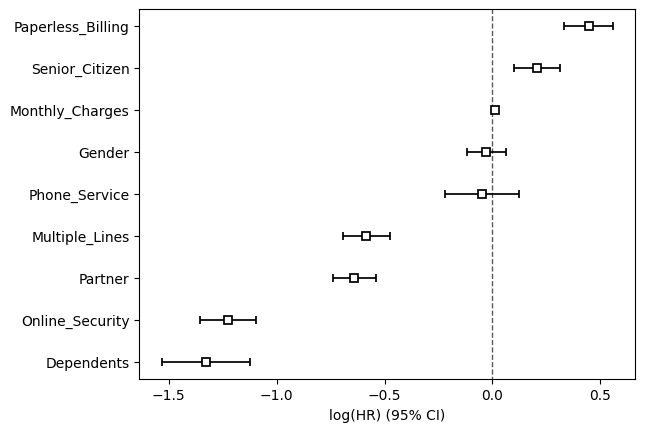

In [10]:
# coefficient estimates and confidence intervals
cph.plot()

## Survival Function

In [11]:
# 顧客ごとの生存関数を予測
surv_func = cph.predict_survival_function(df_limited)
surv_func.head(3)

,0,1,2,3,4,5,6,7,8,9,...,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042
0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,0.966558,0.962697,0.971251,0.983838,0.970775,0.959978,0.880023,0.950143,0.985190,0.968828,...,0.921255,0.991599,0.871492,0.858794,0.917306,0.920334,0.996272,0.984118,0.996071,0.941576
2.0,0.954403,0.949175,0.960767,0.977892,0.960121,0.945499,0.839154,0.932234,0.979736,0.957480,...,0.893566,0.988491,0.828013,0.811504,0.888315,0.892340,0.994889,0.978274,0.994614,0.920720


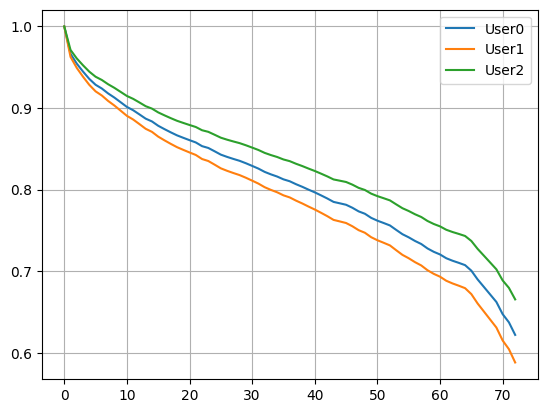

In [12]:
# 各顧客の生存関数をプロット
plt.plot(surv_func.iloc[:, 0].index, surv_func.iloc[:, 0], label='User0')
plt.plot(surv_func.iloc[:, 1].index, surv_func.iloc[:, 1], label='User1')
plt.plot(surv_func.iloc[:, 2].index, surv_func.iloc[:, 2], label='User2')
plt.legend()
plt.grid()

## Effect of varying a covariate
- 他の説明変数を一定にしたままある説明変数を変化させたときに生存関数がどのように変化するかをプロット
- 下図：複数回線を契約している顧客の方が同じ経過時間時点での生存率が高い

<Axes: >

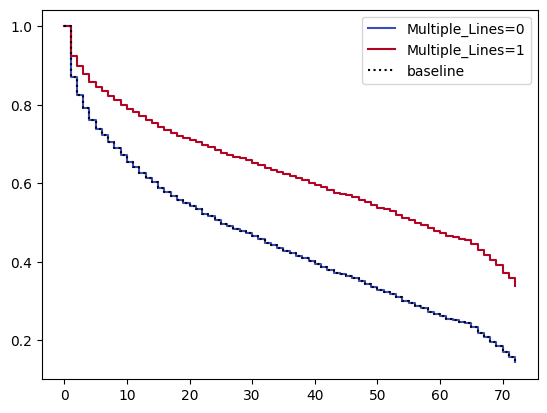

In [13]:
# Multiple_Lines = 0と1の顧客の生存関数をプロット（他の説明変数は固定）
cph.plot_partial_effects_on_outcome(covariates='Multiple_Lines', values=[0, 1], cmap='coolwarm')

## 検定

### 比例ハザードの仮定（Proportional hazard assumption）の検定
- 比例ハザードの仮定 = すべての顧客のハザード関数（の形状）が同一である
  - Cox比例ハザードモデルを利用するときは暗黙的に比例ハザードを仮定することになるため，データがこの仮定を満たしているかを検定する必要がある．
- Statistical Test
  - $H_{0}$: the coefficient is not time-varying
  - $H_{1}$: the coefficient is time-varying (⇔ violation of the proportional hazard assumption)

In [14]:
# Statistical test（重い）
# cph.check_assumptions(df_limited, p_value_threshold=0.05, show_plots=True)

### log-rank検定
- 生存関数間に差があるかどうかの検定
- Statistical test（2つの生存関数を比較する場合．N個への拡張も可．）
  - $H_{0}: h_{1}(t) = h_{2}(t)$（⇔ すべての時点において解約率が等しい）
  - $H_{1}: h_{1}(t) = ch_{2}(t)\ \ (c \neq 1)$

In [15]:
test_res = multivariate_logrank_test(df_limited['Tenure_Months'], df_limited['Multiple_Lines'], df_limited['Churn_Value'])
test_res.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          24.85 <0.005     20.62